In [2]:
# 1. LOAD AND CLEAN DATA
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<ipython-input-4-2686f0e9485e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["log_rooms_per_household"]=(housing["total_rooms"]/housing["households"]).apply(np.log)
<ipython-input-4-2686f0e9485e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing["log_bedrooms_per_household"]=(housing["total_bedrooms"]/housing["households"]).apply(np.log)
<ipython-input-4-2686f0e9485e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>],
       [<Axes: title={'center': 'log_rooms_per_household'}>,
        <Axes: title={'center': 'log_bedrooms_per_household'}>,
        <Axes: title={'center': 'log_population_per_household'}>]],
      dtype=object)

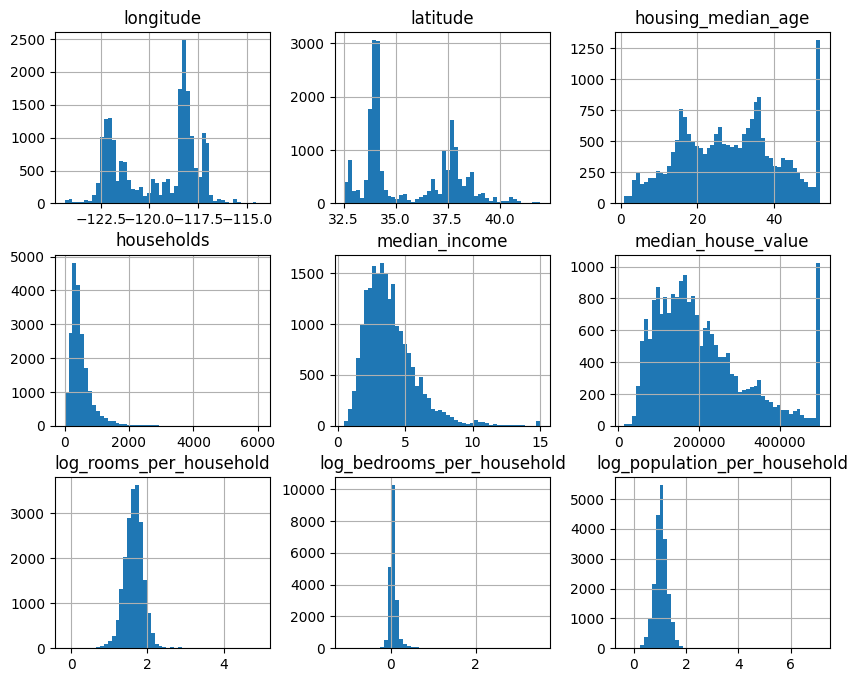

In [4]:
housing = pd.read_csv("drive/MyDrive/data/housing.csv")
housing = housing.drop("ocean_proximity",axis="columns")  # or axis =1
housing = housing.dropna(subset=["total_bedrooms"])

housing["log_rooms_per_household"]=(housing["total_rooms"]/housing["households"]).apply(np.log)
housing["log_bedrooms_per_household"]=(housing["total_bedrooms"]/housing["households"]).apply(np.log)
housing["log_population_per_household"]=(housing["population"]/housing["households"]).apply(np.log)

housing = housing.drop("total_rooms",axis="columns")
housing = housing.drop("total_bedrooms",axis="columns")
housing = housing.drop("population",axis="columns")

housing.hist(bins=50,figsize=(10,8))

In [6]:
# 2. SEPARATE TRAIN AND TEST DATA
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housingtr = train_set.copy()
housingtr_labels = housingtr["median_house_value"].copy()
housingtr_predictors = housingtr.drop("median_house_value", axis="columns")

housingtest = test_set.copy()
housingtest_labels = housingtest["median_house_value"].copy()
housingtest_predictors = housingtest.drop("median_house_value", axis="columns")

In [7]:
#3. RESCALE
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
housingtr_predictors_scaled = min_max_scaler.fit_transform(housingtr_predictors)
housingtest_predictors_scaled = min_max_scaler.fit_transform(housingtest_predictors)

In [10]:
#housingtr_predictors_scaled_pd = pd.DataFrame(housingtr_predictors_scaled)
#housingtr_predictors_scaled_pd.hist(bins=50,figsize=(10,8))

In [12]:
#4. FIT WITH MULTILINEAR REGRESSION
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housingtr_predictors_scaled,housingtr_labels)
lin_reg.coef_, lin_reg.intercept_

(array([-411353.34454058, -388480.04865905,   56940.2529841 ,
          76279.58942331,  635757.94999688, -292391.1603087 ,
         462592.59978318, -687027.58488843]),
 460996.33305346937)

In [16]:
#5. EVALUATE MULTILINEAR REGRESSION PREDICTIONS ON TRAINING DATA
some_data = housingtr_predictors_scaled[1:5]
some_labels = housingtr_labels.iloc[1:5].values
some_data, some_labels, lin_reg.predict(some_data).round(-2)

(array([[0.15338645, 0.63761955, 0.21568627, 0.08863674, 0.04519938,
         0.31212861, 0.26413619, 0.12003318],
        [0.20916335, 0.55579171, 1.        , 0.0930768 , 0.17352864,
         0.33164148, 0.23705711, 0.17602737],
        [0.63446215, 0.1402763 , 0.47058824, 0.02992929, 0.23276231,
         0.3678093 , 0.31827192, 0.23298069],
        [0.46314741, 0.20085016, 0.66666667, 0.06314751, 0.14624626,
         0.28177875, 0.22826479, 0.1197859 ]]),
 array([139300., 215700., 137500., 318800.]),
 array([146400., 225200., 202200., 269100.]))

In [17]:
from sklearn.metrics import mean_squared_error
housing_prediction = lin_reg.predict(housingtr_predictors_scaled)
lin_mse = mean_squared_error(housingtr_labels,housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

66801.29095681156

This is a relative large error given the typical housing value. The model is probably underfitting

In [18]:
#6. FIT WITH DECISION TREE REGRESSION (LEADS TO OVERFITTING)
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housingtr_predictors_scaled,housingtr_labels)
housing_prediction = tree_reg.predict(housingtr_predictors_scaled)
tree_mse = mean_squared_error(housingtr_labels,housing_prediction,squared=False)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Zero error--> The model is probably overfitting

In [19]:
tree_reg.max_features_, tree_reg.feature_importances_,

(8,
 array([0.08413637, 0.09270693, 0.05446529, 0.0344742 , 0.52161199,
        0.05516583, 0.02695611, 0.13048328]))

In [21]:
#7.  K-fold CROSS-VALIDATION from sklearn.model.selection import cross_val_score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg,housingtr_predictors_scaled,housingtr_labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores, "Mean:", tree_rmse_scores.mean(), "Std:", tree_rmse_scores.std()

(array([66960.82660715, 64668.26912547, 68227.98102561, 67854.03687061,
        64452.05724899, 66411.39018098, 68916.23759042, 67930.47235785,
        67518.67426779, 65783.85750995]),
 'Mean:',
 66872.38027848213,
 'Std:',
 1436.5652269793995)

In [22]:
scores = cross_val_score(tree_reg,housingtr_predictors_scaled,housingtr_labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores, "Mean:", tree_rmse_scores.mean(), "Std:", tree_rmse_scores.std()

(array([69082.71827805, 71564.52813037, 69544.65224017, 76273.23073758,
        70743.08702621, 75119.16546542, 69805.7213922 , 77211.56731333,
        69114.09590345, 74580.42537259]),
 'Mean:',
 72303.91918593785,
 'Std:',
 3005.6128607865203)

Now the decision tree doesn’t look as good as it did earlier. In fact, it seems to perform almost as poorly as the linear regression model

In [23]:
#8. TRY RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housingtr_predictors_scaled,housingtr_labels)
housing_prediction = forest_reg.predict(housingtr_predictors_scaled)
forest_mse = mean_squared_error(housingtr_labels,housing_prediction)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18741.561640143318

In [24]:
scores = cross_val_score(forest_reg,housingtr_predictors_scaled,housingtr_labels,scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-scores)
forest_rmse_scores, "Mean:", forest_rmse_scores.mean(), "Std:", forest_rmse_scores.std()

(array([52124.63715283, 49272.96499129, 49943.24874602, 52032.16441664,
        49405.63733938, 51196.81583281, 50355.92173935, 50112.8774044 ,
        50525.30728948, 50919.83155345]),
 'Mean:',
 50588.94064656506,
 'Std:',
 935.6366571725108)

In [25]:
#9. FINE TUNE MODEL (SEE BOOK)

#10. EVALUATE ON TEST SET

# LIN REG
housing_prediction = lin_reg.predict(housingtest_predictors_scaled)
lin_mse = mean_squared_error(housingtest_labels,housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

138311.34187577042

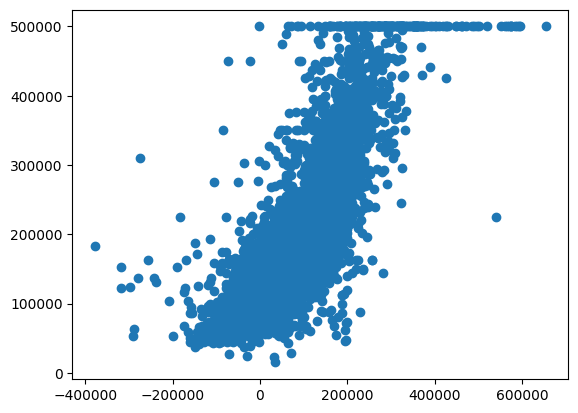

In [26]:
plt.scatter(housing_prediction,housingtest_labels)

In [27]:
# DEC TREE
housing_prediction = tree_reg.predict(housingtest_predictors_scaled)
tree_mse = mean_squared_error(housingtest_labels,housing_prediction)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

103684.52635604795

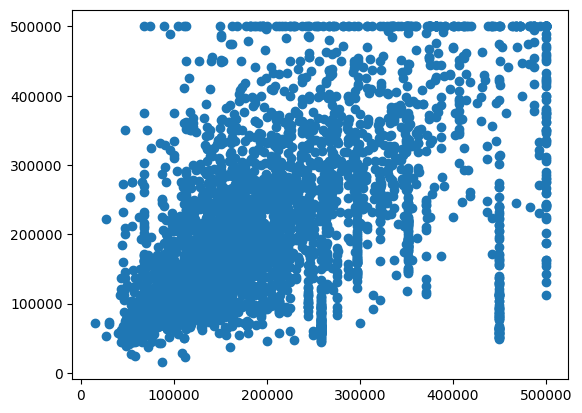

In [28]:
plt.scatter(housing_prediction,housingtest_labels)

In [29]:
# DEC TREE
housing_prediction = forest_reg.predict(housingtest_predictors_scaled)
forest_mse = mean_squared_error(housingtest_labels,housing_prediction)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

71070.2595047791

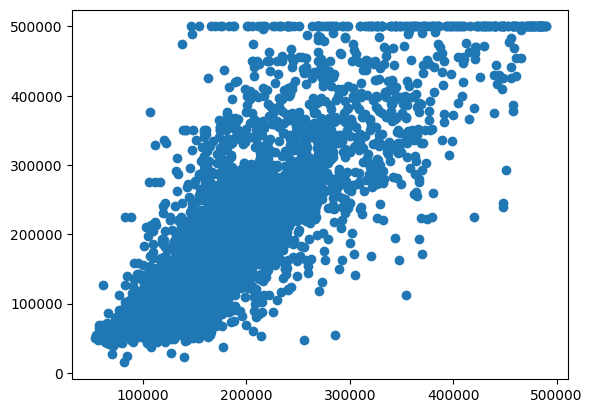

In [30]:
plt.scatter(housing_prediction,housingtest_labels)